In [830]:
import csv
import pandas as pd
import numpy as np
    
data = pd.read_csv('C:\\Users\\Renny\\Desktop\\deep learning assignment 3\\stocks\\A.csv')

In [831]:
price = data[['Close']]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


C:\Users\Renny\AppData\Local\Temp\ipykernel_12152\1688334881.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [832]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


In [833]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [834]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [835]:
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 100


In [836]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    
    
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    


In [837]:
lstm = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim=output_dim, num_layers=num_layers)
gru = GRU(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser_lstm = torch.optim.Adam(lstm.parameters(), lr=0.01)
optimiser_gru = torch.optim.Adam(gru.parameters(), lr=0.01)


In [838]:
#training lstm
import time
print('Training LSTM')
print('\n')
hist_lstm = np.zeros(num_epochs)
start_time = time.time()
lstm_l = []

for t in range(num_epochs):
    y_train_pred_lstm = lstm(x_train)
    
    loss = criterion(y_train_pred_lstm, y_train_lstm)
    print('Epoch: ',t, "MSE: ", loss.item())
    hist_lstm[t] = loss.item()
    
    optimiser_lstm.zero_grad()
    loss.backward()
    optimiser_lstm.step()
    
training_time_lstm = time.time()-start_time
print(f'Training time: {training_time_lstm}')

Training LSTM


Epoch:  0 MSE:  0.6870751976966858
Epoch:  1 MSE:  0.5345780849456787
Epoch:  2 MSE:  0.3979948163032532
Epoch:  3 MSE:  0.25558242201805115
Epoch:  4 MSE:  0.10594692826271057
Epoch:  5 MSE:  0.023708175867795944
Epoch:  6 MSE:  0.15542343258857727
Epoch:  7 MSE:  0.11432633548974991
Epoch:  8 MSE:  0.04522969573736191
Epoch:  9 MSE:  0.022940130904316902
Epoch:  10 MSE:  0.0330950990319252
Epoch:  11 MSE:  0.04845503717660904
Epoch:  12 MSE:  0.05642825365066528
Epoch:  13 MSE:  0.055812254548072815
Epoch:  14 MSE:  0.04935548081994057
Epoch:  15 MSE:  0.04046928137540817
Epoch:  16 MSE:  0.03215648606419563
Epoch:  17 MSE:  0.026535725221037865
Epoch:  18 MSE:  0.024537596851587296
Epoch:  19 MSE:  0.025799531489610672
Epoch:  20 MSE:  0.028900984674692154
Epoch:  21 MSE:  0.031981319189071655
Epoch:  22 MSE:  0.03353044018149376
Epoch:  23 MSE:  0.03295716643333435
Epoch:  24 MSE:  0.030653275549411774
Epoch:  25 MSE:  0.027605226263403893
Epoch:  26 MSE:  0.0248499

In [839]:
import time
print('Training GRU')
print('\n')
hist_gru = np.zeros(num_epochs)
start_time = time.time()
gru_l = []

for t in range(num_epochs):
    y_train_pred_gru = gru(x_train)
    
    loss = criterion(y_train_pred_gru, y_train_gru)
    print('Epoch: ',t, "MSE: ", loss.item())
    hist_gru[t] = loss.item()
    
    optimiser_gru.zero_grad()
    loss.backward()
    optimiser_gru.step()
    
training_time_gru = time.time()-start_time
print(f'Training time: {training_time_gru}')

Training GRU


Epoch:  0 MSE:  0.27089983224868774
Epoch:  1 MSE:  0.09009253233671188
Epoch:  2 MSE:  0.018034476786851883
Epoch:  3 MSE:  0.08972033858299255
Epoch:  4 MSE:  0.0668107345700264
Epoch:  5 MSE:  0.028661582618951797
Epoch:  6 MSE:  0.017286645248532295
Epoch:  7 MSE:  0.02285989187657833
Epoch:  8 MSE:  0.03178476542234421
Epoch:  9 MSE:  0.03692040219902992
Epoch:  10 MSE:  0.036534104496240616
Epoch:  11 MSE:  0.03180037811398506
Epoch:  12 MSE:  0.025047052651643753
Epoch:  13 MSE:  0.018756667152047157
Epoch:  14 MSE:  0.014893198385834694
Epoch:  15 MSE:  0.014315745793282986
Epoch:  16 MSE:  0.016376834362745285
Epoch:  17 MSE:  0.01912827044725418
Epoch:  18 MSE:  0.020427687093615532
Epoch:  19 MSE:  0.019318142905831337
Epoch:  20 MSE:  0.016456956043839455
Epoch:  21 MSE:  0.013334364630281925
Epoch:  22 MSE:  0.011194180697202682
Epoch:  23 MSE:  0.010471433401107788
Epoch:  24 MSE:  0.010846566408872604
Epoch:  25 MSE:  0.01161579042673111
Epoch:  26 MSE:  0

In [840]:
predict_lstm = pd.DataFrame(scaler.inverse_transform(y_train_pred_lstm.detach().numpy()))
predict_gru = pd.DataFrame(scaler.inverse_transform(y_train_pred_gru.detach().numpy()))
original_lstm = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
original_gru = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))


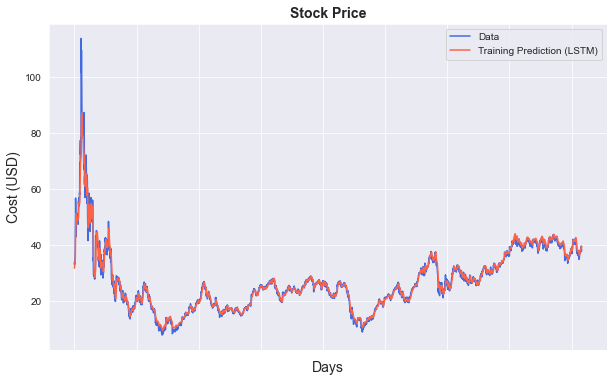

In [841]:
import seaborn as sns
sns.set_style('darkgrid')

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_lstm.index, y=original_lstm[0], label='Data',color='royalblue')
ax = sns.lineplot(x = predict_lstm.index, y=predict_lstm[0], label='Training Prediction (LSTM)',color='tomato')
ax.set_title('Stock Price', size=14, fontweight='bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost (USD)', size = 14)
ax.set_xticklabels('',size = 10)
fig.set_figheight(6)
fig.set_figwidth(10)

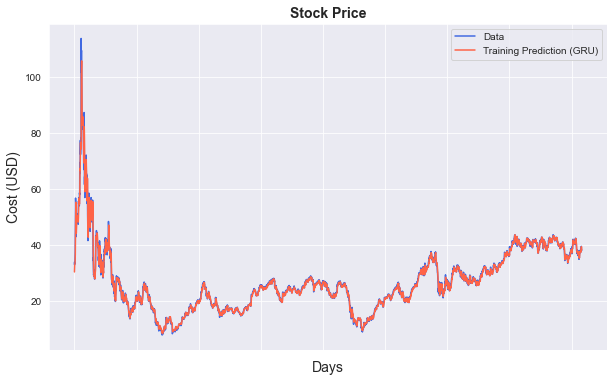

In [842]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_gru.index, y=original_gru[0], label='Data',color='royalblue')
ax = sns.lineplot(x = predict_gru.index, y=predict_gru[0], label='Training Prediction (GRU)',color='tomato')
ax.set_title('Stock Price', size=14, fontweight='bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost (USD)', size = 14)
ax.set_xticklabels('',size = 10)
fig.set_figheight(6)
fig.set_figwidth(10)

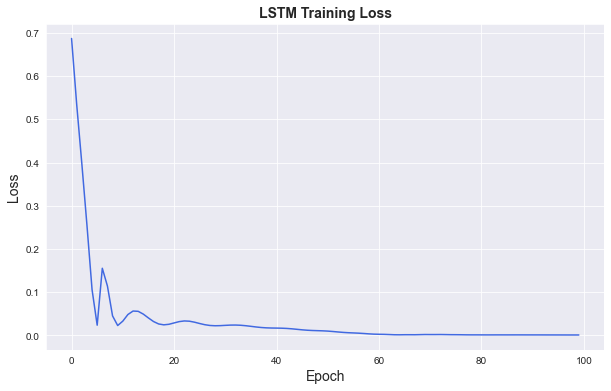

In [843]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1,1,1)
ax = sns.lineplot(data = hist_lstm, color='royalblue')
ax.set_xlabel('Epoch', size = 14)
ax.set_ylabel('Loss', size = 14)
ax.set_title('LSTM Training Loss', size = 14, fontweight='bold')

fig.set_figheight(6)
fig.set_figwidth(10)

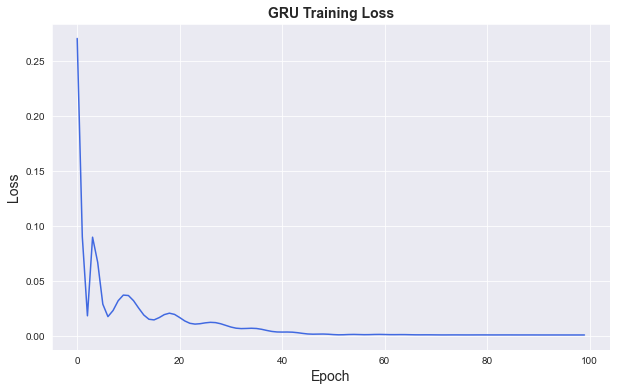

In [844]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1,1,1)
ax = sns.lineplot(data = hist_gru, color='royalblue')
ax.set_xlabel('Epoch', size = 14)
ax.set_ylabel('Loss', size = 14)
ax.set_title('GRU Training Loss', size = 14, fontweight='bold')

fig.set_figheight(6)
fig.set_figwidth(10)

In [845]:
import math, time
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

y_test_pred_lstm = lstm(x_test)

y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
y_train_lstm = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
y_test_lstm = scaler.inverse_transform(y_test_lstm.detach().numpy())

rmse_train_score_lstm = math.sqrt(mean_squared_error(y_train_lstm[:,0], y_train_pred_lstm[:,0]))
print(f'LSTM RMSE Train Score: {round(rmse_train_score_lstm, 2)}')

rmse_test_score_lstm = math.sqrt(mean_squared_error(y_test_lstm[:,0], y_test_pred_lstm[:,0]))
print(f'LSTM RMSE Test Score: {round(rmse_test_score_lstm, 2)}')
print('\n')

mape_train_score_lstm = mean_absolute_percentage_error(y_train_lstm[:,0], y_train_pred_lstm[:,0])
print(f'LSTM MAPE Train Score: {round(mape_train_score_lstm, 4)*100}%')

mape_test_score_lstm = mean_absolute_percentage_error(y_test_lstm[:,0], y_test_pred_lstm[:,0])
print(f'LSTM MAPE Test Score: {round(mape_test_score_lstm, 4)*100}%')
print('\n')

mae_train_score_lstm = mean_absolute_error(y_train_lstm[:,0], y_train_pred_lstm[:,0])
print(f'LSTM MAE Train Score: {mae_train_score_lstm}')

mae_test_score_lstm = mean_absolute_error(y_test_lstm[:,0], y_test_pred_lstm[:,0])
print(f'LSTM MAE Test Score: {mae_test_score_lstm}')
print('\n')

print(f'Training Time: {round(training_time_lstm, 2)} seconds.')




LSTM RMSE Train Score: 1.74
LSTM RMSE Test Score: 2.89


LSTM MAPE Train Score: 3.2900001853704453%
LSTM MAPE Test Score: 3.0500000342726707%


LSTM MAE Train Score: 0.8487411141395569
LSTM MAE Test Score: 2.139620542526245


Training Time: 36.02 seconds.


In [846]:
y_test_pred_gru = gru(x_test)

y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru.detach().numpy())
y_test_gru = scaler.inverse_transform(y_test_gru.detach().numpy())

rmse_train_score_gru = math.sqrt(mean_squared_error(y_train_gru[:,0], y_train_pred_gru[:,0]))
print(f'GRU RMSE Train Score: {round(rmse_train_score_gru, 2)}')

rmse_test_score_gru = math.sqrt(mean_squared_error(y_test_gru[:,0], y_test_pred_gru[:,0]))
print(f'GRU RMSE Test Score: {round(rmse_test_score_gru, 2)}')
print('\n')

mape_train_score_gru = mean_absolute_percentage_error(y_train_gru[:,0], y_train_pred_gru[:,0])
print(f'GRU MAPE Train Score: {round(mape_train_score_gru, 4)*100}%')

mape_test_score_gru = mean_absolute_percentage_error(y_test_gru[:,0], y_test_pred_gru[:,0])
print(f'GRU MAPE Test Score: {round(mape_test_score_gru, 4)*100}%')
print('\n')

mae_train_score_gru = mean_absolute_error(y_train_gru[:,0], y_train_pred_gru[:,0])
print(f'GRU MAE Train Score: {mae_train_score_gru}')

mae_test_score_gru = mean_absolute_error(y_test_gru[:,0], y_test_pred_gru[:,0])
print(f'GRU MAE Test Score: {mae_test_score_gru}')
print('\n')

print(f'GRU Training Time: {round(training_time_gru, 2)} seconds.')




GRU RMSE Train Score: 1.25
GRU RMSE Test Score: 1.18


GRU MAPE Train Score: 2.199999988079071%
GRU MAPE Test Score: 1.209999993443489%


GRU MAE Train Score: 0.5967434048652649
GRU MAE Test Score: 0.7726976871490479


GRU Training Time: 29.56 seconds.


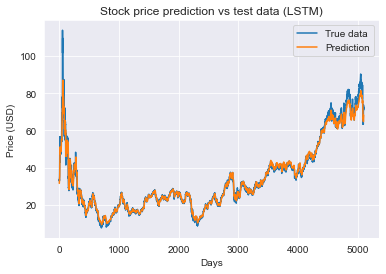

In [847]:
plt.plot(np.concatenate((y_train_lstm, y_test_lstm)), label='True data')
plt.plot(np.concatenate((y_train_pred_lstm, y_test_pred_lstm)), label='Prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.title('Stock price prediction vs test data (LSTM)')
plt.legend()
plt.show()

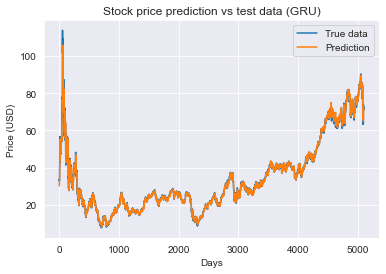

In [848]:
plt.plot(np.concatenate((y_train_gru, y_test_gru)),label='True data')
plt.plot(np.concatenate((y_train_pred_gru, y_test_pred_gru)),label='Prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.title('Stock price prediction vs test data (GRU)')
plt.legend()
plt.show()